In [6]:
import re
from transformers import T5ForConditionalGeneration, T5Tokenizer

In [6]:
import re
from transformers import T5ForConditionalGeneration, T5Tokenizer

# 初始化模型和tokenizer
device = 'cpu'
model_name = 'utrobinmv/t5_translate_en_ru_zh_small_1024'
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# 自定义术语词典（可在此处修改或扩展）
CUSTOM_TERMS = {
    "写入 CSV": "Запись в CSV",
    "CSV 表头": "Заголовок таблицы CSV",
}

prefix = 'translate to ru: '

def translate_text(text, target_lang='ru', term_dict=None):
    """添加term_dict参数接收自定义术语"""
    # 保护路径中的特殊字符
    preserved_paths = re.findall(r'[a-zA-Z]:\\[^ \u4e00-\u9fff]+', text)
    for i, path in enumerate(preserved_paths):
        text = text.replace(path, f"||PATH_{i}||")
    
    # 自定义术语替换
    if term_dict:
        sorted_terms = sorted(term_dict.keys(), 
                            key=lambda x: len(x), 
                            reverse=True)
        pattern = re.compile('|'.join(map(re.escape, sorted_terms)))
        text = pattern.sub(lambda x: term_dict[x.group()], text)
    
    # 执行翻译
    src_text = prefix + text
    input_ids = tokenizer(src_text, return_tensors="pt", max_length=512, truncation=True)
    generated_tokens = model.generate(**input_ids.to(device))
    result = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    
    # 后处理修正
    translated = result[0]
    
    # 恢复被保护的路径
    for i, path in enumerate(preserved_paths):
        translated = translated.replace(f"||PATH_{i}||", path)
    
    # 修正 .py 前空格问题
    translated = re.sub(
        r'(\b[а-яА-ЯёЁ]+)(\.py\b)',
        lambda m: f"{m.group(1)} {m.group(2)}", 
        translated
    )
    
    # 修正标点格式
    translated = re.sub(r'(?<=[а-яА-ЯёЁ])([.,!?])(?=\S)', r' \1', translated)
    
    return translated

def translate_comments_in_code(code_lines):
    translated_lines = []
    translated_count = 0  # 新增注释计数器

    for line in code_lines:
        # 处理纯中文注释行
        pure_comment_match = re.match(r'^(\s*)#\s*([\u4e00-\u9fff].*)', line)
        if pure_comment_match:
            indent = pure_comment_match.group(1)
            chinese_comment = pure_comment_match.group(2)
            translated = translate_text(chinese_comment.strip(), term_dict=CUSTOM_TERMS)
            translated_lines.append(f"{indent}# {translated}\n")
            translated_count += 1
            continue

        # 处理行尾中文注释
        inline_comment_match = re.search(r'(\s+#)\s*([\u4e00-\u9fff][^#]*)', line)
        if inline_comment_match:
            code_part = line[:inline_comment_match.start()]
            comment_symbol = inline_comment_match.group(1)
            chinese_comment = inline_comment_match.group(2).strip()
            translated = translate_text(chinese_comment, term_dict=CUSTOM_TERMS)
            translated_lines.append(f"{code_part}{comment_symbol} {translated}\n")
            translated_count += 1
            continue

        # 处理多行注释
        multi_match = re.match(r'^(\s*)(["\']{3})(.*?)\2', line, re.DOTALL)
        if multi_match:
            indent = multi_match.group(1)
            quote_type = multi_match.group(2)
            comment_content = multi_match.group(3)
            
            if re.search(r'[\u4e00-\u9fff]', comment_content):
                translated = translate_text(comment_content, term_dict=CUSTOM_TERMS)
                translated_lines.append(f"{indent}{quote_type}{translated}{quote_type}\n")
                translated_count += 1
                continue

        translated_lines.append(line)
    
    return translated_lines, translated_count  # 返回两个值

def read_code_file(file_path):
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        return file.readlines()

def save_translated_code(file_path, translated_lines):
    with open(file_path, 'w', encoding='utf-8-sig') as file:
        file.writelines(translated_lines)

def main(input_file_path, output_file_path):
    code_lines = read_code_file(input_file_path)
    translated_lines, comment_count = translate_comments_in_code(code_lines)  # 接收计数
    save_translated_code(output_file_path, translated_lines)
    print(f"Translation completed → {output_file}")
    print(f"Translated {comment_count} Chinese comments")  # 新增统计输出

if __name__ == "__main__":
    input_file = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\c2e2r_2.py'
    output_file = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_c2e2r_2_微调前.py'
    main(input_file, output_file)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Translation completed → C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_c2e2r_2_微调前.py
Translated 35 Chinese comments


### 微调

1. 环境准备

In [7]:
!pip install transformers[torch] datasets sentencepiece rouge-score

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24989 sha256=f0547b1e0bb0b96d7d3308c7d3472e4ca34fade8e14884b64927e8fc23fd54a1
  Stored in directory: c:\users\gdnjr5233_yolo\appdata\local\pip\cache\wheels\5f\dd\89\461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


2. 导入依赖

In [22]:
import re
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    TrainerCallback
)
from rouge_score import rouge_scorer

3. 数据准备

In [23]:
# 加载数据集
# 读取CSV并转换为Dataset
df = pd.read_csv(r"C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\datasets\data.csv")
dataset = load_dataset('csv', data_files={'train': r"C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\datasets\data.csv"})

# 添加T5所需前缀
def add_prefix(example):
    example["input_text"] = f"translate to ru: {example['comment_zh']}"
    example["target_text"] = example["comment_ru"]
    return example

dataset = dataset.map(add_prefix)
dataset

DatasetDict({
    train: Dataset({
        features: ['file_path', 'code', 'code_comment_type', 'comment_zh', 'comment_ru', 'comment_en', 'input_text', 'target_text'],
        num_rows: 1258
    })
})

Null value check:
file_path            0
code                 0
code_comment_type    0
comment_zh           0
comment_ru           0
comment_en           0
dtype: int64


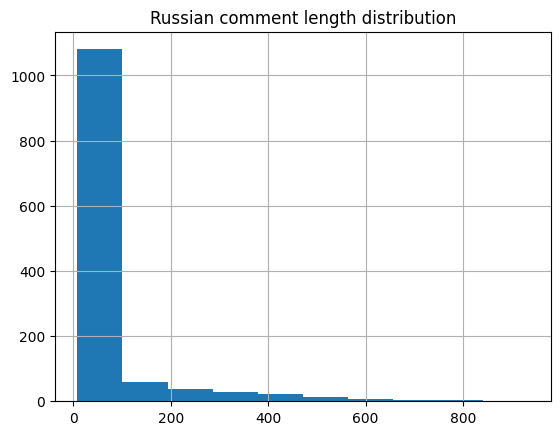

In [24]:
# 检查数据集中是否有空值
print("Null value check:")
print(df.isnull().sum())

# 检查俄语注释长度分布
import matplotlib.pyplot as plt
df['comment_ru'].str.len().hist()
plt.title("Russian comment length distribution")
plt.show()

4. 数据预处理

In [25]:
# 数据过滤
def filter_invalid_data(example):
    return (
        example["comment_ru"] is not None and
        len(example["comment_ru"]) > 0 and
        len(example["comment_zh"]) < 500 and
        len(example["comment_ru"]) < 500
    )

dataset = dataset.filter(filter_invalid_data, num_proc=4)

# 数据集划分
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['file_path', 'code', 'code_comment_type', 'comment_zh', 'comment_ru', 'comment_en', 'input_text', 'target_text'],
        num_rows: 984
    })
    test: Dataset({
        features: ['file_path', 'code', 'code_comment_type', 'comment_zh', 'comment_ru', 'comment_en', 'input_text', 'target_text'],
        num_rows: 247
    })
})

In [3]:
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['file_path', 'code', 'code_comment_type', 'comment_zh', 'comment_ru', 'comment_en', 'input_text', 'target_text'],
        num_rows: 1006
    })
    test: Dataset({
        features: ['file_path', 'code', 'code_comment_type', 'comment_zh', 'comment_ru', 'comment_en', 'input_text', 'target_text'],
        num_rows: 252
    })
})

5. 加载模型和分词器

In [26]:
from transformers import T5ForConditionalGeneration, T5Tokenizer


model_name = "utrobinmv/t5_translate_en_ru_zh_small_1024"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


6. 定义评估指标

In [27]:
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # 处理标签中的-100
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # 计算ROUGE-L
    scores = [scorer.score(pred, label)['rougeL'].fmeasure 
             for pred, label in zip(decoded_preds, decoded_labels)]
    
    return {"rougeL": round(np.mean(scores), 4)}


7. 数据预处理函数

In [34]:
from transformers import T5Tokenizer
from functools import partial
import torch

# 加载分词器
tokenizer = T5Tokenizer.from_pretrained("utrobinmv/t5_translate_en_ru_zh_small_1024")

def preprocess_function(examples, tokenizer):
    """增强型预处理函数，包含多重安全验证"""
    try:
        # 输入处理（中文）
        model_inputs = tokenizer(
            examples["input_text"],
            max_length=256,
            truncation="only_first",  # 优先截断前半部分
            padding="max_length",
            add_special_tokens=True,
            return_tensors="pt"
        )
        
        # 标签处理（俄语）
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(
                text_target=examples["target_text"],
                max_length=256,
                truncation="longest_first",  # 智能截断
                padding="max_length",
                add_special_tokens=True,
                return_tensors="pt"
            )

        # 双重有效性验证
        input_ids = model_inputs["input_ids"].flatten().tolist()
        label_ids = labels["input_ids"].flatten().tolist()
        
        input_invalid = any(i >= tokenizer.vocab_size for i in input_ids)
        label_invalid = any(i >= tokenizer.vocab_size for i in label_ids)
        
        # 检查特殊token
        has_unk = tokenizer.unk_token_id in input_ids + label_ids
        
        if input_invalid or label_invalid or has_unk:
            invalid_count = sum(i >= tokenizer.vocab_size for i in input_ids + label_ids)
            print(f"过滤样本 | 非法token数: {invalid_count} | UNK存在: {has_unk}")
            return {}  # 返回空字典过滤该样本

        # 转换为PyTorch张量
        model_inputs["input_ids"] = model_inputs["input_ids"].squeeze()
        model_inputs["attention_mask"] = model_inputs["attention_mask"].squeeze()
        model_inputs["labels"] = labels["input_ids"].squeeze()
        
        return model_inputs
    except Exception as e:
        print(f"预处理异常: {str(e)}")
        return {}

# 创建绑定分词器的预处理函数
preprocess_with_tokenizer = partial(preprocess_function, tokenizer=tokenizer)

# 应用预处理
try:
    tokenized_datasets = dataset.map(
        preprocess_with_tokenizer,
        batched=True,
        batch_size=32,
        num_proc=4,
        remove_columns=dataset["train"].column_names,
        load_from_cache_file=False,
        desc="处理数据批次"
    )
except Exception as e:
    print(f"多进程预处理失败: {str(e)}")
    print("尝试单进程模式...")
    tokenized_datasets = dataset.map(
        preprocess_with_tokenizer,
        batched=True,
        batch_size=8,
        num_proc=1,
        desc="安全模式处理"
    )

# 过滤空数据（关键步骤）
def filter_empty_samples(example):
    return len(example["input_ids"]) > 0

tokenized_datasets = tokenized_datasets.filter(
    filter_empty_samples,
    num_proc=2,
    desc="过滤空样本"
)

# 数据验证
print("\n预处理结果统计:")
print(f"剩余训练样本: {len(tokenized_datasets['train'])}")
print(f"剩余验证样本: {len(tokenized_datasets['test'])}")

# 样本解码验证
sample_idx = 42
print("\n样本验证:")
print("原始输入:", dataset["train"]["input_text"][sample_idx])
print("预处理输入:", tokenizer.decode(tokenized_datasets["train"][sample_idx]["input_ids"]))
print("预处理标签:", tokenizer.decode(tokenized_datasets["train"][sample_idx]["labels"]))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


处理数据批次 (num_proc=4):   0%|          | 0/984 [00:00<?, ? examples/s]

处理数据批次 (num_proc=4):   0%|          | 0/247 [00:00<?, ? examples/s]

过滤空样本 (num_proc=2):   0%|          | 0/984 [00:00<?, ? examples/s]

过滤空样本 (num_proc=2):   0%|          | 0/247 [00:00<?, ? examples/s]


预处理结果统计:
剩余训练样本: 984
剩余验证样本: 247

样本验证:
原始输入: translate to ru: 计算调整后的 GMV，规则如下：
预处理输入: translate to ru: 计算调整后的 GMV,规则如下:</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [ ]:
# 修改预处理函数（关键修复）
def preprocess_function(examples, tokenizer):
    try:
        # 输入处理
        model_inputs = tokenizer(
            examples["input_text"],
            max_length=256,
            truncation=True,
            padding="max_length",
            add_special_tokens=True,
            return_tensors="pt"
        )
        
        # 标签处理
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(
                text_target=examples["target_text"],
                max_length=256,
                truncation=True,
                padding="max_length",
                add_special_tokens=True,
                return_tensors="pt"
            )
        
        # 双重有效性验证
        input_invalid = [i for i in model_inputs["input_ids"].flatten() if i >= tokenizer.vocab_size]
        label_invalid = [i for i in labels["input_ids"].flatten() if i >= tokenizer.vocab_size]
        
        if input_invalid or label_invalid:
            print(f"跳过非法样本（输入非法token数: {len(input_invalid)}, 标签非法token数: {len(label_invalid)}）")
            print("示例输入:", examples["input_text"][0][:100])
            return {}  # 返回空字典以过滤该样本
        
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs
    except Exception as e:
        print(f"预处理异常: {str(e)}")
        return {}

In [ ]:
from transformers import T5Tokenizer
from functools import partial

# 1. 先加载tokenizer
tokenizer = T5Tokenizer.from_pretrained("utrobinmv/t5_translate_en_ru_zh_small_1024")

# 2. 定义带tokenizer参数的预处理函数

def preprocess_function(examples, tokenizer):
    # 输入处理
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=256,
        truncation=True,
        padding="max_length",
        add_special_tokens=True,
        return_tensors="pt"
    )
    
    # 标签处理
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            text_target=examples["target_text"],
            max_length=256,
            truncation=True,
            padding="max_length",
            add_special_tokens=True,
            return_tensors="pt"
        )
    
    # 有效性验证
    invalid_tokens = [tid for tid in labels["input_ids"].flatten() 
                     if tid >= tokenizer.vocab_size]
    if invalid_tokens:
        print(f"无效token: {invalid_tokens[:5]}")
        raise ValueError("存在非法token")
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# 3. 创建部分函数绑定tokenizer
preprocess_with_tokenizer = partial(
    preprocess_function,
    tokenizer=tokenizer
)

# 4. 应用预处理
try:
    tokenized_datasets = dataset.map(
        preprocess_with_tokenizer,
        batched=True,
        batch_size=32,
        num_proc=4,
        remove_columns=dataset["train"].column_names,
        load_from_cache_file=False
    )
except Exception as e:
    print(f"预处理失败: {str(e)}")
    # 回退到单进程模式
    print("尝试单进程模式...")
    tokenized_datasets = dataset.map(
        preprocess_with_tokenizer,
        batched=True,
        batch_size=8,
        num_proc=1
    )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map (num_proc=4):   0%|          | 0/984 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/247 [00:00<?, ? examples/s]

In [30]:
# 验证数据集结构
print("预处理后数据集结构:", tokenized_datasets)

# 检查样本格式
sample = tokenized_datasets["train"][0]
print("\n样例输入ID:", sample["input_ids"][:10])
print("样例标签ID:", sample["labels"][:10])

# 解码验证
input_text = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)
label_text = tokenizer.decode(sample["labels"], skip_special_tokens=True)
print(f"\n解码验证:\n输入: {input_text}\n标签: {label_text}")

预处理后数据集结构: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 984
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 247
    })
})

样例输入ID: [21809, 19, 4, 2248, 31, 4, 338, 4606, 29, 18543]
样例标签ID: [247, 46635, 707, 2952, 14190, 18543, 9, 12451, 182, 1]

解码验证:
输入: translate to ru: 使用具体的 API 调用
标签: Использовать конкретные API-звонки


In [28]:
max_input_length = 256
max_target_length = 256

def preprocess_function(examples):
    # 输入处理
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
        add_special_tokens=True,
        return_tensors="pt"
    )
    
    # 标签处理
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            text_target=examples["target_text"],
            max_length=max_target_length,
            truncation=True,
            padding="max_length",
            add_special_tokens=True,
            return_tensors="pt"
        )
    
    # 有效性验证
    invalid_tokens = [tid for tid in labels["input_ids"].flatten() 
                     if tid >= tokenizer.vocab_size]
    if invalid_tokens:
        print(f"无效token: {invalid_tokens[:5]}")
        print("问题样本:", examples["input_text"][0])
        raise ValueError("存在非法token")
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# 应用预处理
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    batch_size=32,
    num_proc=4,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False
)

Map (num_proc=4):   0%|          | 0/984 [00:00<?, ? examples/s]

NameError: name 'tokenizer' is not defined

8. 训练配置

In [ ]:
# training_args = Seq2SeqTrainingArguments(
#     output_dir="./optimized-model",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=1e-4,
#     per_device_train_batch_size=4,
#     gradient_accumulation_steps=4,
#     num_train_epochs=3,
#     optim="adafactor",
#     adafactor_relative_step=False,
#     adafactor_scale_parameter=True,
#     gradient_checkpointing=True,
#     max_grad_norm=1.0,
#     lr_scheduler_type="cosine",
#     warmup_ratio=0.1,
#     weight_decay=0.005,
#     fp16=False,
#     logging_steps=50,
#     dataloader_num_workers=0,
#     no_cuda=True,
#     load_best_model_at_end=True,
#     metric_for_best_model="rougeL",
#     greater_is_better=True,
#     report_to="none"
# )

In [ ]:
# training_args = Seq2SeqTrainingArguments(
#     output_dir="./t5-translate-finetuned",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=3e-5,
#     per_device_train_batch_size=2,
#     per_device_eval_batch_size=2,
#     gradient_accumulation_steps=2,
#     num_train_epochs=5,
#     weight_decay=0.01,
#     predict_with_generate=True,
#     fp16=False,
#     logging_steps=100,
#     load_best_model_at_end=True,
#     metric_for_best_model="rougeL",
#     greater_is_better=True,
#     report_to="none",
#     dataloader_num_workers=0,
#     no_cuda=True  # 明确使用CPU
# )

In [31]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-translate-finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4,  # 增大batch_size
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,  # 总batch_size=4*2=8
    num_train_epochs=5,
    weight_decay=0.01,
    predict_with_generate=True,
    fp16=False,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    greater_is_better=True,
    report_to="none",
    dataloader_num_workers=0,
    no_cuda=True,
    # 新增优化参数
    gradient_checkpointing=True,  # 内存优化
    optim="adafactor"            # 更高效的优化器
)

c:\Python310\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Python310\lib\site-packages\transformers\training_args.py:1489: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


9. 安全回调

In [32]:
class SafetyCheckCallback(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        inputs = kwargs.get("inputs")
        if inputs and "labels" in inputs:
            labels = inputs["labels"].cpu().numpy()
            invalid_ids = [i for i in labels.flatten() if i >= tokenizer.vocab_size]
            if invalid_ids:
                print(f"\n[安全警报] 检测到无效token: {invalid_ids[:5]}")
                control.should_training_stop = True

10. 创建Trainer

In [33]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[SafetyCheckCallback()]
)

# 开始训练
trainer.train()

  0%|          | 0/615 [00:00<?, ?it/s]

c:\Python310\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


{'loss': 0.0956, 'grad_norm': 0.26741698384284973, 'learning_rate': 2.5121951219512197e-05, 'epoch': 0.81}


  0%|          | 0/62 [00:00<?, ?it/s]

IndexError: piece id is out of range.

11. 保存模型

In [ ]:
trainer.save_model("./t5-translate-finetuned-final")
tokenizer.save_pretrained("./t5-translate-finetuned-final")

12. 最终评估

In [ ]:
eval_results = trainer.evaluate()
print(f"最终评估结果: {eval_results}")

### -

*5) 数据预处理*

In [ ]:
def preprocess_function(examples):
    # 输入文本处理
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=256,
        truncation=True,
        padding="max_length",
        add_special_tokens=True
    )
    
    # 标签处理（关键修复部分）
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            text_target=examples["target_text"],  # 明确指定处理目标文本
            max_length=256,
            truncation=True,
            padding="max_length",
            add_special_tokens=True
        )
    
    # 验证标签有效性
    if any(i >= tokenizer.vocab_size for i in labels["input_ids"]):
        raise ValueError("检测到超出词汇表的token")
        
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [15]:
max_input_length = 256
max_target_length = 256

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=max_input_length,
        truncation=True,
        padding="max_length"
    )
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["target_text"],
            max_length=max_target_length,
            truncation=True,
            padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["input_text", "target_text"] + dataset["train"].column_names
)

Map:   0%|          | 0/1006 [00:00<?, ? examples/s]

c:\Python310\lib\site-packages\transformers\tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/252 [00:00<?, ? examples/s]

*6) 训练配置*

In [22]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# training_args = Seq2SeqTrainingArguments(
#     output_dir="./t5-translate-finetuned",
#     evaluation_strategy="epoch",
#     learning_rate=3e-5,
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     weight_decay=0.01,
#     save_total_limit=3,
#     num_train_epochs=15,
#     predict_with_generate=True,
#     fp16=True,  # 如果使用GPU
#     logging_steps=50,
# )


# training_args = Seq2SeqTrainingArguments(
#     output_dir="./t5-translate-finetuned-cpu",
#     evaluation_strategy="epoch",
#     learning_rate=3e-5,
#     per_device_train_batch_size=2,
#     per_device_eval_batch_size=2,
#     gradient_accumulation_steps=2,
#     weight_decay=0.01,
#     save_total_limit=2,
#     num_train_epochs=1,
#     predict_with_generate=True,
#     fp16=False,
#     logging_steps=100,
#     dataloader_num_workers=0,
#     no_cuda=True,
#     load_best_model_at_end=True,  # 新增：保存最佳模型
#     metric_for_best_model="rougeL",  # 根据评估指标选择最佳模型
#     greater_is_better=True
# )

training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-translate-finetuned-cpu",
    evaluation_strategy="epoch",
    save_strategy="epoch",  # 必须与评估策略一致
    learning_rate=3e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=5,  # 恢复原始epoch数
    predict_with_generate=True,
    fp16=False,
    logging_steps=100,
    dataloader_num_workers=0,
    no_cuda=True,
    load_best_model_at_end=True,  # 保存最佳模型
    metric_for_best_model="rougeL",  # 根据评估指标选择最佳模型
    greater_is_better=True,
    report_to="none"
)

c:\Python310\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Python310\lib\site-packages\transformers\training_args.py:1489: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


*7) 定义评估指标*

In [23]:
import numpy as np
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # 替换-100为pad token id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # 计算ROUGE-L
    scores = [scorer.score(pred, label)['rougeL'].fmeasure 
             for pred, label in zip(decoded_preds, decoded_labels)]
    
    return {"rougeL": round(np.mean(scores), 4)}

*8) 开始训练*

In [24]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/1255 [00:00<?, ?it/s]

{'loss': 0.117, 'grad_norm': 1.0339211225509644, 'learning_rate': 2.760956175298805e-05, 'epoch': 0.4}
{'loss': 0.1091, 'grad_norm': 1.5766521692276, 'learning_rate': 2.5219123505976097e-05, 'epoch': 0.8}


  0%|          | 0/126 [00:00<?, ?it/s]

IndexError: piece id is out of range.

*9) 保存微调后的模型*

In [ ]:
model.save_pretrained("./t5-translate-finetuned-final")
tokenizer.save_pretrained("./t5-translate-finetuned-final")

### 翻译质量评估
*1) 自动评估指标*

In [ ]:
# 在测试集上评估
test_results = trainer.evaluate(tokenized_datasets["test"])
print(f"Final ROUGE-L: {test_results['eval_rougeL']}")

# 对比原始模型性能
original_model = T5ForConditionalGeneration.from_pretrained(model_name)
original_trainer = Seq2SeqTrainer(
    model=original_model,
    args=training_args,
    compute_metrics=compute_metrics
)
original_results = original_trainer.evaluate(tokenized_datasets["test"])
print(f"Original ROUGE-L: {original_results['eval_rougeL']}")

2) 人工评估方法

In [ ]:
# 生成对比样本
test_samples = dataset["test"].shuffle(seed=42).select(range(20))

def generate_translation(model, text):
    inputs = tokenizer(f"translate to ru: {text}", return_tensors="pt", max_length=256, truncation=True)
    outputs = model.generate(**inputs)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

for sample in test_samples:
    original_translation = generate_translation(original_model, sample["comment_zh"])
    finetuned_translation = generate_translation(model, sample["comment_zh"])
    
    print(f"原文: {sample['comment_zh']}")
    print(f"参考答案: {sample['comment_ru']}")
    print(f"原始模型: {original_translation}")
    print(f"微调模型: {finetuned_translation}\n")

### Helsinki-NLP/opus-mt-zh-ru

In [21]:
import re
from transformers import MarianMTModel, MarianTokenizer

# 初始化专业中俄翻译模型
model_name = "Helsinki-NLP/opus-mt-zh-ru"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)
model.to('cpu')

# 术语保护字典 (扩展版)
term_dict = {
    # 技术术语
    "CSV": "CSV",
    "Python": "Python",
    "UTF-8": "UTF-8",
    # 功能术语
    "表头": "заголовок таблицы",
    "写入 CSV": "записать в CSV",
    "单行注释": "однострочный комментарий",
    "多行注释": "многострочный комментарий"
}

def translate_text(text):
    # 保护术语
    protected_text = text
    for cn, ru in term_dict.items():
        protected_text = protected_text.replace(cn, f"[[{cn}]]")

    # 执行翻译
    inputs = tokenizer([protected_text], return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(**inputs)
    translated = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # 恢复术语
    for cn, ru in term_dict.items():
        translated = translated.replace(f"[[{cn}]]", ru)

    # 格式修正
    translated = re.sub(r'(?<! )(\.py\b)', r' .py', translated)  # 修正.py前空格
    translated = re.sub(r'(\b[а-я]{3,})([A-Z])', r'\1 \2', translated)  # 分隔俄语单词和大写字母
    
    return translated

def translate_comments_in_code(code_lines):
    translated_lines = []
    
    for line in code_lines:
        # 严格匹配纯中文注释行
        if re.match(r'^(\s*)#\s*[\u4e00-\u9fff]+.*', line):
            indent = re.match(r'^(\s*)', line).group(1)
            comment = re.sub(r'^#\s*', '', line).strip()
            translated = translate_text(comment)
            translated_lines.append(f"{indent}# {translated}\n")
            continue
        
        # 处理行尾中文注释
        if '#' in line and re.search(r'[\u4e00-\u9fff]', line):
            parts = line.split('#', 1)
            code_part, comment_part = parts
            if re.search(r'[\u4e00-\u9fff]', comment_part):
                translated = translate_text(comment_part.strip())
                translated_lines.append(f"{code_part}# {translated}\n")
                continue
        
        # 处理多行注释
        if '"""' in line or "'''" in line:
            match = re.match(r'^(\s*)(["\']{3})(.*?)\2', line, re.DOTALL)
            if match and re.search(r'[\u4e00-\u9fff]', match.group(3)):
                indent = match.group(1)
                quote = match.group(2)
                content = match.group(3)
                translated = translate_text(content)
                translated_lines.append(f"{indent}{quote}{translated}{quote}\n")
                continue
        
        translated_lines.append(line)
    
    return translated_lines

def read_code_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.readlines()

def save_translated_code(file_path, translated_lines):
    with open(file_path, 'w', encoding='utf-8') as file:
        file.writelines(translated_lines)

def main(input_file_path, output_file_path):
    code_lines = read_code_file(input_file_path)
    translated_lines = translate_comments_in_code(code_lines)
    save_translated_code(output_file_path, translated_lines)

if __name__ == "__main__":
    input_file = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\c2e2r.py'
    output_file = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_final_2.py'
    main(input_file, output_file)
    print(f"翻译完成 → {output_file}")

OSError: Helsinki-NLP/opus-mt-zh-ru is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

# -

In [ ]:
import re
from transformers import T5ForConditionalGeneration, T5Tokenizer

# 初始化模型和tokenizer
device = 'cpu'
model_name = 'utrobinmv/t5_translate_en_ru_zh_small_1024'
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# 自定义术语词典（可在此处修改或扩展）
CUSTOM_TERMS = {
    "写入 CSV": "Запись в CSV",
    "CSV 表头": "Заголовок таблицы CSV",
    }

prefix = 'translate to ru: '

def translate_text(text, target_lang='ru', term_dict=None):
    """添加term_dict参数接收自定义术语"""
    # 保护路径中的特殊字符
    preserved_paths = re.findall(r'[a-zA-Z]:\\[^ \u4e00-\u9fff]+', text)
    for i, path in enumerate(preserved_paths):
        text = text.replace(path, f"||PATH_{i}||")
    
    # 自定义术语替换（新增部分）
    if term_dict:
        # 按术语长度降序排序避免部分匹配
        sorted_terms = sorted(term_dict.keys(), 
                            key=lambda x: len(x), 
                            reverse=True)
        pattern = re.compile('|'.join(map(re.escape, sorted_terms)))
        # 直接替换为对应的俄语术语
        text = pattern.sub(lambda x: term_dict[x.group()], text)
    
    # 执行翻译
    src_text = prefix + text
    input_ids = tokenizer(src_text, return_tensors="pt", max_length=512, truncation=True)
    generated_tokens = model.generate(**input_ids.to(device))
    result = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    
    # 后处理修正
    translated = result[0]
    
    # 恢复被保护的路径
    for i, path in enumerate(preserved_paths):
        translated = translated.replace(f"||PATH_{i}||", path)
    
    # 修正 .py 前空格问题
    translated = re.sub(
        r'(\b[а-яА-ЯёЁ]+)(\.py\b)',
        lambda m: f"{m.group(1)} {m.group(2)}", 
        translated
    )
    
    # 修正标点格式
    translated = re.sub(r'(?<=[а-яА-ЯёЁ])([.,!?])(?=\S)', r' \1', translated)
    
    return translated

def translate_comments_in_code(code_lines):
    translated_lines = []
    
    for line in code_lines:
        # 处理纯中文注释行
        pure_comment_match = re.match(r'^(\s*)#\s*([\u4e00-\u9fff].*)', line)
        if pure_comment_match:
            indent = pure_comment_match.group(1)
            chinese_comment = pure_comment_match.group(2)
            # 传递术语词典（新增参数）
            translated = translate_text(chinese_comment.strip(), term_dict=CUSTOM_TERMS)
            translated_lines.append(f"{indent}# {translated}\n")
            continue

        # 处理行尾中文注释
        inline_comment_match = re.search(r'(\s+#)\s*([\u4e00-\u9fff][^#]*)', line)
        if inline_comment_match:
            code_part = line[:inline_comment_match.start()]
            comment_symbol = inline_comment_match.group(1)
            chinese_comment = inline_comment_match.group(2).strip()
            # 传递术语词典（新增参数）
            translated = translate_text(chinese_comment, term_dict=CUSTOM_TERMS)
            translated_lines.append(f"{code_part}{comment_symbol} {translated}\n")
            continue

        # 处理多行注释
        multi_match = re.match(r'^(\s*)(["\']{3})(.*?)\2', line, re.DOTALL)
        if multi_match:
            indent = multi_match.group(1)
            quote_type = multi_match.group(2)
            comment_content = multi_match.group(3)
            
            if re.search(r'[\u4e00-\u9fff]', comment_content):
                # 传递术语词典（新增参数）
                translated = translate_text(comment_content, term_dict=CUSTOM_TERMS)
                translated_lines.append(f"{indent}{quote_type}{translated}{quote_type}\n")
                continue

        translated_lines.append(line)
    
    return translated_lines

def read_code_file(file_path):
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        return file.readlines()

def save_translated_code(file_path, translated_lines):
    with open(file_path, 'w', encoding='utf-8-sig') as file:
        file.writelines(translated_lines)

def main(input_file_path, output_file_path):
    code_lines = read_code_file(input_file_path)
    translated_lines = translate_comments_in_code(code_lines)
    save_translated_code(output_file_path, translated_lines)

if __name__ == "__main__":
    input_file = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\c2e2r_2.py'
    output_file = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_c2e2r_2.py'
    main(input_file, output_file)
    print(f"翻译完成 → {output_file}")

In [ ]:
import re
import os
from transformers import T5ForConditionalGeneration, T5Tokenizer

# 初始化模型和tokenizer
device = 'cpu'
model_name = 'utrobinmv/t5_translate_en_ru_zh_small_1024'
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# 自定义术语词典（按术语长度降序排列）
CUSTOM_TERMS = {
    "CSV 表头": "Заголовок таблицы CSV",
    "写入 CSV": "Запись в CSV",
    "PDF 文件": "PDF-документ",
    "CSV": "CSV",
    "PDF": "PDF"
}

# 安全替换字典（修正模型固有翻译习惯）
SAFE_REPLACEMENTS = {
    "КСВ": "CSV",
    "ксв": "csv",
    "ПДФ": "PDF",
    "пдф": "pdf"
}

prefix = 'translate to ru: '

def translate_text(text, target_lang='ru', term_dict=None):
    """改进后的翻译函数，包含完整术语保护机制"""
    # 第一阶段：保护特殊内容
    preserved = {}
    
    # 1. 保护文件路径
    path_pattern = re.compile(r'[a-zA-Z]:\\[^ \u4e00-\u9fff]+')
    for i, match in enumerate(path_pattern.finditer(text)):
        placeholder = f"||PATH_{i}||"
        preserved[placeholder] = match.group()
        text = text.replace(match.group(), placeholder)
    
    # 2. 保护自定义术语
    term_placeholders = {}
    if term_dict:
        sorted_terms = sorted(term_dict.keys(), key=len, reverse=True)
        for idx, term in enumerate(sorted_terms):
            placeholder = f"||TERM_{idx}||"
            term_placeholders[placeholder] = term_dict[term]
            text = re.sub(re.escape(term), placeholder, text)
    
    # 执行翻译
    src_text = prefix + text
    input_ids = tokenizer(src_text, return_tensors="pt", max_length=512, truncation=True)
    generated_tokens = model.generate(**input_ids.to(device))
    translated = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
    
    # 第二阶段：恢复和修正
    # 1. 恢复术语（优先处理）
    for ph, term in term_placeholders.items():
        translated = translated.replace(ph, term)
    
    # 2. 安全替换
    for wrong, correct in SAFE_REPLACEMENTS.items():
        translated = translated.replace(wrong, correct)
    
    # 3. 恢复路径
    for ph, path in preserved.items():
        translated = translated.replace(ph, path)
    
    # 后处理修正
    translated = re.sub(r'(\b[а-яА-ЯёЁ]+)(\.py\b)', r'\1 \2', translated)  # .py前空格
    translated = re.sub(r'(?<=[а-яА-ЯёЁ])([.,!?])(?=\S)', r' \1', translated)  # 标点符号
    
    return translated

def translate_comments_in_code(code_lines):
    translated_lines = []
    
    for line in code_lines:
        # 处理单行注释
        if pure_comment := re.match(r'^(\s*)#\s*([\u4e00-\u9fff].*)', line):
            indent, comment = pure_comment.groups()
            translated = translate_text(comment.strip(), term_dict=CUSTOM_TERMS)
            translated_lines.append(f"{indent}# {translated}\n")
            continue
        
        # 处理行尾注释
        if inline_comment := re.search(r'(\s+#)\s*([\u4e00-\u9fff][^#]*)', line):
            code_part = line[:inline_comment.start()]
            symbol, comment = inline_comment.groups()
            translated = translate_text(comment.strip(), term_dict=CUSTOM_TERMS)
            translated_lines.append(f"{code_part}{symbol} {translated}\n")
            continue
        
        # 处理多行注释
        if multi_comment := re.match(r'^(\s*)(["\']{3})(.*?)\2', line, re.DOTALL):
            indent, quote, content = multi_comment.groups()
            if re.search(r'[\u4e00-\u9fff]', content):
                translated = translate_text(content, term_dict=CUSTOM_TERMS)
                translated_lines.append(f"{indent}{quote}{translated}{quote}\n")
                continue
        
        translated_lines.append(line)
    
    return translated_lines

def read_code_file(file_path):
    with open(file_path, 'r', encoding='utf-8-sig') as f:
        return f.readlines()

def save_translated_code(file_path, lines):
    with open(file_path, 'w', encoding='utf-8-sig') as f:
        f.writelines(lines)

def main(input_file, output_file):
    code_lines = read_code_file(input_file)
    translated = translate_comments_in_code(code_lines)
    save_translated_code(output_file, translated)

if __name__ == "__main__":
    input_path = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\c2e2r.py'
    output_path = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_18.py'
    main(input_path, output_path)
    print(f"翻译完成 → {output_path}")

In [ ]:
import re
from transformers import T5ForConditionalGeneration, T5Tokenizer

# 初始化模型和tokenizer
device = 'cpu'  # 使用 CPU
model_name = 'utrobinmv/t5_translate_en_ru_zh_small_1024'
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)
tokenizer = T5Tokenizer.from_pretrained(model_name)

prefix = 'translate to ru: '  # 更明确的翻译指令

def translate_text(text, target_lang='ru'):
    # 保护路径中的特殊字符
    preserved_paths = re.findall(r'[a-zA-Z]:\\[^ \u4e00-\u9fff]+', text)
    for i, path in enumerate(preserved_paths):
        text = text.replace(path, f"||PATH_{i}||")
    
    # 执行翻译
    src_text = prefix + text
    input_ids = tokenizer(src_text, return_tensors="pt", max_length=512, truncation=True)
    generated_tokens = model.generate(**input_ids.to(device))
    result = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    
    # 后处理修正
    translated = result[0]
    
    # 恢复被保护的路径
    for i, path in enumerate(preserved_paths):
        translated = translated.replace(f"||PATH_{i}||", path)
    
    # 修正 .py 前空格问题
    translated = re.sub(
        r'(\b[а-яА-ЯёЁ]+)(\.py\b)',
        lambda m: f"{m.group(1)} {m.group(2)}", 
        translated
    )
    
    # 修正标点格式
    translated = re.sub(r'(?<=[а-яА-ЯёЁ])([.,!?])(?=\S)', r' \1', translated)
    
    return translated

def read_code_file(file_path):
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        return file.readlines()

def save_translated_code(file_path, translated_lines):
    with open(file_path, 'w', encoding='utf-8-sig') as file:
        file.writelines(translated_lines)

def translate_comments_in_code(code_lines):
    translated_lines = []
    
    for line in code_lines:
        # 处理纯中文注释行
        pure_comment_match = re.match(r'^(\s*)#\s*([\u4e00-\u9fff].*)', line)
        if pure_comment_match:
            indent = pure_comment_match.group(1)
            chinese_comment = pure_comment_match.group(2)
            translated = translate_text(chinese_comment.strip())
            translated_lines.append(f"{indent}# {translated}\n")
            continue

        # 处理行尾中文注释
        inline_comment_match = re.search(r'(\s+#)\s*([\u4e00-\u9fff][^#]*)', line)
        if inline_comment_match:
            code_part = line[:inline_comment_match.start()]
            comment_symbol = inline_comment_match.group(1)
            chinese_comment = inline_comment_match.group(2).strip()
            translated = translate_text(chinese_comment)
            translated_lines.append(f"{code_part}{comment_symbol} {translated}\n")
            continue

        # 处理多行注释
        multi_match = re.match(r'^(\s*)(["\']{3})(.*?)\2', line, re.DOTALL)
        if multi_match:
            indent = multi_match.group(1)
            quote_type = multi_match.group(2)
            comment_content = multi_match.group(3)
            
            if re.search(r'[\u4e00-\u9fff]', comment_content):
                translated = translate_text(comment_content)
                translated_lines.append(f"{indent}{quote_type}{translated}{quote_type}\n")
                continue

        translated_lines.append(line)
    
    return translated_lines

def main(input_file_path, output_file_path):
    code_lines = read_code_file(input_file_path)
    translated_lines = translate_comments_in_code(code_lines)
    save_translated_code(output_file_path, translated_lines)

if __name__ == "__main__":
    input_file = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\c2e2r_2.py'
    output_file = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_c2e2r_2.py'
    
    # input_file = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\c2e2r.py'
    # output_file = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_c2e2r.py'
    
    main(input_file, output_file)
    print(f"翻译完成 → {output_file}")

In [ ]:
import re
from transformers import T5ForConditionalGeneration, T5Tokenizer

# 初始化模型和tokenizer
device = 'cpu'
model_name = 'utrobinmv/t5_translate_en_ru_zh_small_1024'
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)
tokenizer = T5Tokenizer.from_pretrained(model_name)

prefix = 'translate to ru: '  # 翻译指令

def translate_text(text, target_lang='ru'):
    
    # 自定义术语词典
    term_dict = {
        "表头": "Заголовок таблицы",
        "写入 CSV": "Запись в CSV",
        "CSV": "CSV"  # 保留CSV不翻译
    }
    
    # 保护术语
    for cn, ru in term_dict.items():
        text = text.replace(cn, f"||TERM_{cn}||")
    
    # 保护路径
    preserved_paths = re.findall(r'[a-zA-Z]:\\[^ \u4e00-\u9fff]+', text)
    for i, path in enumerate(preserved_paths):
        text = text.replace(path, f"||PATH_{i}||")
    
    # 执行翻译
    src_text = prefix + text
    input_ids = tokenizer(src_text, return_tensors="pt", max_length=512, truncation=True)
    generated_tokens = model.generate(**input_ids.to(device))
    result = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    
    # 后处理
    translated = result[0]
    
    # 恢复路径
    for i, path in enumerate(preserved_paths):
        translated = translated.replace(f"||PATH_{i}||", path)
    
    # 恢复术语
    for cn, ru in term_dict.items():
        translated = translated.replace(f"||TERM_{cn}||", ru)
    
    # 格式修正
    translated = re.sub(r'(\b[а-яА-ЯёЁ]+)(\.py\b)', r'\1 \2', translated)
    translated = re.sub(r'(?<=[а-яА-ЯёЁ])([.,!?])(?=\S)', r' \1', translated)
    
    return translated

def read_code_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.readlines()

def save_translated_code(file_path, translated_lines):
    with open(file_path, 'w', encoding='utf-8') as file:
        file.writelines(translated_lines)

def translate_comments_in_code(code_lines):
    translated_lines = []
    
    for line in code_lines:
        # 增强注释匹配
        comment_match = re.match(r'^(\s*)#\s*([\u4e00-\u9fff].*?[a-zA-Z]*)', line)
        if comment_match:
            indent = comment_match.group(1)
            comment_content = comment_match.group(2)
            translated = translate_text(comment_content.strip())
            translated_lines.append(f"{indent}# {translated}\n")
            continue

        # 增强行尾注释处理
        inline_match = re.search(r'(\s+#)\s*([\u4e00-\u9fff].*?[a-zA-Z]*)', line)
        if inline_match:
            code_part = line[:inline_match.start()]
            symbol = inline_match.group(1)
            comment = inline_match.group(2)
            translated = translate_text(comment.strip())
            translated_lines.append(f"{code_part}{symbol} {translated}\n")
            continue

        # 处理多行注释
        multi_match = re.match(r'^(\s*)(["\']{3})(.*?)\2', line, re.DOTALL)
        if multi_match:
            indent = multi_match.group(1)
            quote_type = multi_match.group(2)
            comment_content = multi_match.group(3)
            
            if re.search(r'[\u4e00-\u9fff]', comment_content):
                translated = translate_text(comment_content)
                translated_lines.append(f"{indent}{quote_type}{translated}{quote_type}\n")
                continue

        translated_lines.append(line)
    
    return translated_lines

def main(input_file_path, output_file_path):
    code_lines = read_code_file(input_file_path)
    translated_lines = translate_comments_in_code(code_lines)
    save_translated_code(output_file_path, translated_lines)

if __name__ == "__main__":
    input_file = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\c2e2r.py'
    output_file = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_16.py'
    main(input_file, output_file)
    print(f"翻译完成 → {output_file}")

In [13]:
# 初始化模型和tokenizer
device = 'cpu'  # 使用 CPU
model_name = 'utrobinmv/t5_translate_en_ru_zh_small_1024'
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)
tokenizer = T5Tokenizer.from_pretrained(model_name)

prefix = 'translate to ru: '  # 指定目标语言为俄语

# 用于翻译函数
def translate_text(text, target_lang='ru'):
    src_text = prefix + text  # 添加翻译前缀
    input_ids = tokenizer(src_text, return_tensors="pt")
    generated_tokens = model.generate(**input_ids.to(device))
    result = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    # return result[0]
    
    # 添加后处理修正
    translated = result[0]
    
    # 修正 ".py" 前的空格问题（匹配俄语单词+标点模式）
    translated = re.sub(
        r'(\b[а-яА-ЯёЁ]+)(\.py\b)', 
        lambda m: f"{m.group(1)} {m.group(2)}", 
        translated
    )
    
    # 修正其他常见标点格式（可选）
    translated = re.sub(r'(?<=[а-яА-ЯёЁ])([.,!?])', r' \1', translated)
    
    return translated

# 读取原始代码文件
def read_code_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.readlines()

# 保存翻译后的代码到新文件
def save_translated_code(file_path, translated_lines):
    with open(file_path, 'w', encoding='utf-8') as file:
        file.writelines(translated_lines)

# 翻译代码注释
def translate_comments_in_code(code_lines):
    translated_lines = []
    
    for line in code_lines:
        # 精确匹配纯中文注释行（示例： # 注释内容）
        pure_comment_match = re.match(r'^(\s*)#\s*([\u4e00-\u9fff].*)', line)
        if pure_comment_match:
            indent = pure_comment_match.group(1)
            chinese_comment = pure_comment_match.group(2)
            
            translated = translate_text(chinese_comment.strip())
            translated_lines.append(f"{indent}# {translated}\n")
            continue

        # 匹配行尾中文注释（示例： code...  # 注释内容）
        inline_comment_match = re.search(r'(\s+#)\s*([\u4e00-\u9fff][^#]*)', line)
        if inline_comment_match:
            code_part = line[:inline_comment_match.start()]
            comment_symbol = inline_comment_match.group(1)
            chinese_comment = inline_comment_match.group(2).strip()
            
            translated = translate_text(chinese_comment)
            translated_line = f"{code_part}{comment_symbol} {translated}\n"
            translated_lines.append(translated_line)
            continue

        # 多行注释处理（保持原有逻辑）
        multi_match = re.match(r'^(\s*)(["\']{3})(.*?)\2', line, re.DOTALL)
        if multi_match:
            indent = multi_match.group(1)
            quote_type = multi_match.group(2)
            comment_content = multi_match.group(3)
            
            if re.search(r'[\u4e00-\u9fff]', comment_content):
                translated = translate_text(comment_content)
                translated_lines.append(f"{indent}{quote_type}{translated}{quote_type}\n")
                continue

        translated_lines.append(line)
    
    return translated_lines

# 主流程
def main(input_file_path, output_file_path):
    code_lines = read_code_file(input_file_path)  # 读取代码文件
    translated_lines = translate_comments_in_code(code_lines)  # 翻译注释
    save_translated_code(output_file_path, translated_lines)  # 保存翻译后的文件

# 示例调用
input_file_path = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\c2e2r.py'  # 输入的 Python 文件路径
output_file_path = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_13.py'  # 输出的翻译后的文件路径
main(input_file_path, output_file_path)

print(f"翻译后的代码文件已保存至: {output_file_path}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


翻译后的代码文件已保存至: C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_13.py


In [ ]:
import re
from transformers import T5ForConditionalGeneration, T5Tokenizer

# 初始化模型和tokenizer
device = 'cpu'  # 使用 CPU
model_name = 'utrobinmv/t5_translate_en_ru_zh_small_1024'
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)
tokenizer = T5Tokenizer.from_pretrained(model_name)

prefix = 'translate to ru: '  # 指定目标语言为俄语

# 用于翻译函数
def translate_text(text, target_lang='ru'):
    src_text = prefix + text  # 添加翻译前缀
    input_ids = tokenizer(src_text, return_tensors="pt")
    generated_tokens = model.generate(**input_ids.to(device))
    result = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    return result[0]

# 读取原始代码文件
def read_code_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.readlines()

# 保存翻译后的代码到新文件
def save_translated_code(file_path, translated_lines):
    with open(file_path, 'w', encoding='utf-8') as file:
        file.writelines(translated_lines)

# 识别并翻译注释
# def translate_comments_in_code(code_lines):
#     translated_lines = []
    
#     for line in code_lines:
#         # 匹配单行注释
#         single_comment_pattern = r'#(.*)'  # 只匹配#后面的内容
#         match = re.search(single_comment_pattern, line)
        
#         if match:
#             comment_text = match.group(1).strip()  # 获取注释内容
#             # 如果注释是中文，则翻译
#             if re.search(r'[\u4e00-\u9fff]', comment_text):  # 检查是否包含中文字符
#                 translated_comment = translate_text(comment_text, target_lang='ru')
#                 # 替换原注释，保持格式
#                 line = line.replace(comment_text, ' ' + translated_comment)
        
#         # 处理多行注释
#         multi_comment_pattern = r'""".*?"""|\'\'\'.*?\'\'\''  # 处理三引号注释
#         multi_match = re.search(multi_comment_pattern, line, re.DOTALL)
        
#         if multi_match:
#             comment_text = multi_match.group(0)
#             # 如果多行注释是中文，则翻译
#             if re.search(r'[\u4e00-\u9fff]', comment_text):  # 检查是否包含中文字符
#                 translated_comment = translate_text(comment_text, target_lang='ru')
#                 # 保持原来的注释符号，替换注释内容
#                 line = line.replace(comment_text, '"""' + translated_comment + '"""')
        
#         translated_lines.append(line)
    
#     return translated_lines

# 修改2：优化注释匹配和替换逻辑
# def translate_comments_in_code(code_lines):
#     translated_lines = []
    
#     for line in code_lines:
#         # 单行注释处理（优化正则）
#         if '#' in line:
#             parts = line.split('#', 1)
#             code_part, comment_part = parts[0], parts[1]
#             if re.search(r'[\u4e00-\u9fff]', comment_part):
#                 translated = translate_text(comment_part.strip())
#                 translated_lines.append(f"{code_part}# {translated}\n")
#                 continue

#         # 多行注释处理（优化正则和替换逻辑）
#         multi_match = re.search(r'("""|\'\'\')(.*?)\1', line, re.DOTALL)
#         if multi_match:
#             quote_type = multi_match.group(1)
#             comment_content = multi_match.group(2)
#             if re.search(r'[\u4e00-\u9fff]', comment_content):
#                 translated = translate_text(comment_content)
#                 translated_lines.append(f"{quote_type}{translated}{quote_type}\n")
#                 continue

#         translated_lines.append(line)
    
#     return translated_lines

# def translate_comments_in_code(code_lines):
#     translated_lines = []
    
#     for line in code_lines:
#         # 单行注释处理（已保留缩进）
#         if '#' in line:
#             parts = line.split('#', 1)
#             code_part, comment_part = parts[0], parts[1]
#             if re.search(r'[\u4e00-\u9fff]', comment_part):
#                 translated = translate_text(comment_part.strip())
#                 translated_lines.append(f"{code_part}# {translated}\n")
#                 continue

#         # 多行注释处理（新增缩进捕获）
#         multi_match = re.match(r'^(\s*)(["\']{3})(.*?)\2', line, re.DOTALL)
#         if multi_match:
#             indent = multi_match.group(1)  # 捕获缩进
#             quote_type = multi_match.group(2)
#             comment_content = multi_match.group(3)
            
#             if re.search(r'[\u4e00-\u9fff]', comment_content):
#                 translated = translate_text(comment_content)
#                 # 保留原始缩进和引号结构
#                 translated_lines.append(f"{indent}{quote_type}{translated}{quote_type}\n")
#                 continue

#         translated_lines.append(line)
    
#     return translated_lines

def translate_comments_in_code(code_lines):
    translated_lines = []
    
    for line in code_lines:
        # 精确匹配纯中文注释行（示例： # 注释内容）
        pure_comment_match = re.match(r'^(\s*)#\s*([\u4e00-\u9fff].*)', line)
        if pure_comment_match:
            indent = pure_comment_match.group(1)
            chinese_comment = pure_comment_match.group(2)
            
            translated = translate_text(chinese_comment.strip())
            translated_lines.append(f"{indent}# {translated}\n")
            continue

        # 匹配行尾中文注释（示例： code...  # 注释内容）
        inline_comment_match = re.search(r'(\s+#)\s*([\u4e00-\u9fff][^#]*)', line)
        if inline_comment_match:
            code_part = line[:inline_comment_match.start()]
            comment_symbol = inline_comment_match.group(1)
            chinese_comment = inline_comment_match.group(2).strip()
            
            translated = translate_text(chinese_comment)
            translated_line = f"{code_part}{comment_symbol} {translated}\n"
            translated_lines.append(translated_line)
            continue

        # 多行注释处理（保持原有逻辑）
        multi_match = re.match(r'^(\s*)(["\']{3})(.*?)\2', line, re.DOTALL)
        if multi_match:
            indent = multi_match.group(1)
            quote_type = multi_match.group(2)
            comment_content = multi_match.group(3)
            
            if re.search(r'[\u4e00-\u9fff]', comment_content):
                translated = translate_text(comment_content)
                translated_lines.append(f"{indent}{quote_type}{translated}{quote_type}\n")
                continue

        translated_lines.append(line)
    
    return translated_lines

# 主流程
def main(input_file_path, output_file_path):
    code_lines = read_code_file(input_file_path)  # 读取代码文件
    translated_lines = translate_comments_in_code(code_lines)  # 翻译注释
    save_translated_code(output_file_path, translated_lines)  # 保存翻译后的文件

# 示例调用
input_file_path = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\c2e2r.py'  # 输入的 Python 文件路径
output_file_path = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_12.py'  # 输出的翻译后的文件路径
main(input_file_path, output_file_path)

print(f"翻译后的代码文件已保存至: {output_file_path}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


翻译后的代码文件已保存至: C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_12.py


In [ ]:
import re
from transformers import T5ForConditionalGeneration, T5Tokenizer

# 初始化模型和tokenizer
device = 'cpu'  # 使用 CPU
model_name = 'utrobinmv/t5_translate_en_ru_zh_small_1024'
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)
tokenizer = T5Tokenizer.from_pretrained(model_name)

prefix = 'translate to ru: '  # 指定目标语言为俄语

# 用于翻译函数
def translate_text(text, target_lang='ru'):
    src_text = prefix + text  # 添加翻译前缀
    input_ids = tokenizer(src_text, return_tensors="pt")
    generated_tokens = model.generate(**input_ids.to(device))
    result = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    return result[0]

# 读取原始代码文件
def read_code_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.readlines()

# 保存翻译后的代码到新文件
def save_translated_code(file_path, translated_lines):
    with open(file_path, 'w', encoding='utf-8') as file:
        file.writelines(translated_lines)

# 识别并翻译注释
# def translate_comments_in_code(code_lines):
#     translated_lines = []
    
#     for line in code_lines:
#         # 匹配单行注释
#         single_comment_pattern = r'#(.*)'  # 只匹配#后面的内容
#         match = re.search(single_comment_pattern, line)
        
#         if match:
#             comment_text = match.group(1).strip()  # 获取注释内容
#             # 如果注释是中文，则翻译
#             if re.search(r'[\u4e00-\u9fff]', comment_text):  # 检查是否包含中文字符
#                 translated_comment = translate_text(comment_text, target_lang='ru')
#                 # 替换原注释，保持格式
#                 line = line.replace(comment_text, ' ' + translated_comment)
        
#         # 处理多行注释
#         multi_comment_pattern = r'""".*?"""|\'\'\'.*?\'\'\''  # 处理三引号注释
#         multi_match = re.search(multi_comment_pattern, line, re.DOTALL)
        
#         if multi_match:
#             comment_text = multi_match.group(0)
#             # 如果多行注释是中文，则翻译
#             if re.search(r'[\u4e00-\u9fff]', comment_text):  # 检查是否包含中文字符
#                 translated_comment = translate_text(comment_text, target_lang='ru')
#                 # 保持原来的注释符号，替换注释内容
#                 line = line.replace(comment_text, '"""' + translated_comment + '"""')
        
#         translated_lines.append(line)
    
#     return translated_lines

# 修改2：优化注释匹配和替换逻辑
# def translate_comments_in_code(code_lines):
#     translated_lines = []
    
#     for line in code_lines:
#         # 单行注释处理（优化正则）
#         if '#' in line:
#             parts = line.split('#', 1)
#             code_part, comment_part = parts[0], parts[1]
#             if re.search(r'[\u4e00-\u9fff]', comment_part):
#                 translated = translate_text(comment_part.strip())
#                 translated_lines.append(f"{code_part}# {translated}\n")
#                 continue

#         # 多行注释处理（优化正则和替换逻辑）
#         multi_match = re.search(r'("""|\'\'\')(.*?)\1', line, re.DOTALL)
#         if multi_match:
#             quote_type = multi_match.group(1)
#             comment_content = multi_match.group(2)
#             if re.search(r'[\u4e00-\u9fff]', comment_content):
#                 translated = translate_text(comment_content)
#                 translated_lines.append(f"{quote_type}{translated}{quote_type}\n")
#                 continue

#         translated_lines.append(line)
    
#     return translated_lines

def translate_comments_in_code(code_lines):
    translated_lines = []
    
    for line in code_lines:
        # 单行注释处理（已保留缩进）
        if '#' in line:
            parts = line.split('#', 1)
            code_part, comment_part = parts[0], parts[1]
            if re.search(r'[\u4e00-\u9fff]', comment_part):
                translated = translate_text(comment_part.strip())
                translated_lines.append(f"{code_part}# {translated}\n")
                continue

        # 多行注释处理（新增缩进捕获）
        multi_match = re.match(r'^(\s*)(["\']{3})(.*?)\2', line, re.DOTALL)
        if multi_match:
            indent = multi_match.group(1)  # 捕获缩进
            quote_type = multi_match.group(2)
            comment_content = multi_match.group(3)
            
            if re.search(r'[\u4e00-\u9fff]', comment_content):
                translated = translate_text(comment_content)
                # 保留原始缩进和引号结构
                translated_lines.append(f"{indent}{quote_type}{translated}{quote_type}\n")
                continue

        translated_lines.append(line)
    
    return translated_lines

# 主流程
def main(input_file_path, output_file_path):
    code_lines = read_code_file(input_file_path)  # 读取代码文件
    translated_lines = translate_comments_in_code(code_lines)  # 翻译注释
    save_translated_code(output_file_path, translated_lines)  # 保存翻译后的文件

# 示例调用
input_file_path = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\c2e2r.py'  # 输入的 Python 文件路径
output_file_path = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_11.py'  # 输出的翻译后的文件路径
main(input_file_path, output_file_path)

print(f"翻译后的代码文件已保存至: {output_file_path}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


翻译后的代码文件已保存至: C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_11.py


In [2]:
# 初始化模型和tokenizer 
device = 'cpu'  # 使用 CPU
model_name = 'utrobinmv/t5_translate_en_ru_zh_small_1024'
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)
tokenizer = T5Tokenizer.from_pretrained(model_name)

prefix = 'translate to russian: '  # 指定目标语言为俄语

# 用于翻译函数
def translate_text(text, target_lang='ru'):
    src_text = prefix + text  # 添加翻译前缀
    input_ids = tokenizer(src_text, return_tensors="pt")
    generated_tokens = model.generate(**input_ids.to(device))
    result = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    return result[0]

# 读取原始代码文件
def read_code_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.readlines()

# 保存翻译后的代码到新文件
def save_translated_code(file_path, translated_lines):
    with open(file_path, 'w', encoding='utf-8') as file:
        file.writelines(translated_lines)

# 识别并翻译注释
def translate_comments_in_code(code_lines):
    translated_lines = []
    
    for line in code_lines:
        # 匹配单行注释
        single_comment_pattern = r'#(.*)'  # 只匹配#后面的内容
        match = re.search(single_comment_pattern, line)
        
        if match:
            comment_text = match.group(1).strip()  # 获取注释内容
            # 如果注释是中文，则翻译
            if re.search(r'[\u4e00-\u9fff]', comment_text):  # 检查是否包含中文字符
                translated_comment = translate_text(comment_text, target_lang='ru')
                # 替换原注释，保持格式
                line = line.replace(comment_text, ' ' + translated_comment)
        
        # 处理多行注释
        multi_comment_pattern = r'""".*?"""|\'\'\'.*?\'\'\''  # 处理三引号注释
        multi_match = re.search(multi_comment_pattern, line, re.DOTALL)
        
        if multi_match:
            comment_text = multi_match.group(0)
            # 如果多行注释是中文，则翻译
            if re.search(r'[\u4e00-\u9fff]', comment_text):  # 检查是否包含中文字符
                translated_comment = translate_text(comment_text, target_lang='ru')
                # 保持原来的注释符号，替换注释内容
                line = line.replace(comment_text, '"""' + translated_comment + '"""')
        
        translated_lines.append(line)
    
    return translated_lines

# 主流程
def main(input_file_path, output_file_path):
    code_lines = read_code_file(input_file_path)  # 读取代码文件
    translated_lines = translate_comments_in_code(code_lines)  # 翻译注释
    save_translated_code(output_file_path, translated_lines)  # 保存翻译后的文件

# 示例调用
input_file_path = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\c2e2r.py'  # 输入的 Python 文件路径
output_file_path = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_9.py'  # 输出的翻译后的文件路径
main(input_file_path, output_file_path)

print(f"翻译后的代码文件已保存至: {output_file_path}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


翻译后的代码文件已保存至: C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_9.py


In [4]:
# 初始化模型和tokenizer
device = 'cpu'  # 使用 CPU
model_name = 'utrobinmv/t5_translate_en_ru_zh_small_1024'
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)
tokenizer = T5Tokenizer.from_pretrained(model_name)

prefix = 'translate to russian: '  # 指定目标语言为俄语

# 用于翻译函数
def translate_text(text, target_lang='ru'):
    src_text = prefix + text  # 添加翻译前缀
    input_ids = tokenizer(src_text, return_tensors="pt")
    generated_tokens = model.generate(**input_ids.to(device))
    result = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    return result[0]

# 读取原始代码文件
def read_code_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.readlines()

# 保存翻译后的代码到新文件
def save_translated_code(file_path, translated_lines):
    with open(file_path, 'w', encoding='utf-8') as file:
        file.writelines(translated_lines)

# 识别并翻译注释
def translate_comments_in_code(code_lines):
    translated_lines = []
    
    for line in code_lines:
        # 匹配单行注释
        single_comment_pattern = r'#(.*)'  # 只匹配#后面的内容
        match = re.search(single_comment_pattern, line)
        
        if match:
            comment_text = match.group(1).strip()  # 获取注释内容
            # 如果注释是中文，则翻译
            if re.search(r'[\u4e00-\u9fff]', comment_text):  # 检查是否包含中文字符
                translated_comment = translate_text(comment_text, target_lang='ru')
                # 替换原注释，保持格式
                line = line.replace(comment_text, ' ' + translated_comment)
        
        # 处理多行注释
        multi_comment_pattern = r'""".*?"""|\'\'\'.*?\'\'\''  # 处理三引号注释
        multi_match = re.search(multi_comment_pattern, line, re.DOTALL)
        
        if multi_match:
            comment_text = multi_match.group(0)
            # 如果多行注释是中文，则翻译
            if re.search(r'[\u4e00-\u9fff]', comment_text):  # 检查是否包含中文字符
                translated_comment = translate_text(comment_text, target_lang='ru')
                # 保持原来的注释符号，替换注释内容
                line = line.replace(comment_text, '""' + translated_comment + '""')
        
        translated_lines.append(line)
    
    return translated_lines

# 主流程
def main(input_file_path, output_file_path):
    code_lines = read_code_file(input_file_path)  # 读取代码文件
    translated_lines = translate_comments_in_code(code_lines)  # 翻译注释
    save_translated_code(output_file_path, translated_lines)  # 保存翻译后的文件

# 示例调用
input_file_path = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\c2e2r.py'  # 输入的 Python 文件路径
output_file_path = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_8.py'  # 输出的翻译后的文件路径
main(input_file_path, output_file_path)

print(f"翻译后的代码文件已保存至: {output_file_path}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


翻译后的代码文件已保存至: C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_8.py


In [ ]:
# 初始化模型和tokenizer
device = 'cpu'  # 使用 CPU
model_name = 'utrobinmv/t5_translate_en_ru_zh_small_1024'
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)
tokenizer = T5Tokenizer.from_pretrained(model_name)

prefix = 'translate to russian: '

# 用于翻译函数
def translate_text(text, target_lang='ru'):
    src_text = prefix + text
    input_ids = tokenizer(src_text, return_tensors="pt")
    generated_tokens = model.generate(**input_ids.to(device))
    result = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    return result[0]

# 读取原始代码文件
def read_code_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.readlines()

# 保存翻译后的代码到新文件
def save_translated_code(file_path, translated_lines):
    with open(file_path, 'w', encoding='utf-8') as file:
        file.writelines(translated_lines)

# 识别并翻译注释
def translate_comments_in_code(code_lines):
    translated_lines = []
    
    for line in code_lines:
        # 匹配单行注释
        single_comment_pattern = r'#(.*)'
        match = re.search(single_comment_pattern, line)
        
        if match:
            comment_text = match.group(1).strip()  # 获取注释内容
            # 如果注释是中文，则翻译
            if re.search(r'[\u4e00-\u9fff]', comment_text):  # 中文字符
                translated_comment = translate_text(comment_text, target_lang='ru')
                # 替换原注释
                line = line.replace(comment_text, translated_comment)
        
        # 处理多行注释
        multi_comment_pattern = r'""".*?"""|\'\'\'.*?\'\'\''
        multi_match = re.search(multi_comment_pattern, line, re.DOTALL)
        
        if multi_match:
            comment_text = multi_match.group(0)
            # 如果多行注释是中文，则翻译
            if re.search(r'[\u4e00-\u9fff]', comment_text):  # 中文字符
                translated_comment = translate_text(comment_text, target_lang='ru')
                line = line.replace(comment_text, translated_comment)
        
        translated_lines.append(line)
    
    return translated_lines

# 主流程
def main(input_file_path, output_file_path):
    code_lines = read_code_file(input_file_path)  # 读取代码文件
    translated_lines = translate_comments_in_code(code_lines)  # 翻译注释
    save_translated_code(output_file_path, translated_lines)  # 保存翻译后的文件

# 示例调用
input_file_path = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\c2e2r.py'  # 输入的 Python 文件路径
output_file_path = r'C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_7.py'  # 输出的翻译后的文件路径
main(input_file_path, output_file_path)

print(f"翻译后的代码文件已保存至: {output_file_path}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


翻译后的代码文件已保存至: C:\Users\gdnjr5233_YOLO\Desktop\ВКР_2025\translated_test_7.py
